In [13]:
import sys, getopt
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
import scipy.optimize
from matplotlib import cm
from functools import partial
from scipy.special import softmax
from scipy.special import log_softmax
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erf

# Multiclass classification of $K$ clusters
The notebook compute training error, training loss and generalisation error for the classification task of $K$ Gaussian clouds, each one with covariance $\Sigma=\Delta I$. The dataset is given as a set $\{(\mathbf y^\nu,\mathbf x^\nu)\}_{\nu=1}^n$ generated via the probability density
$$p(\mathbf y,\mathbf x)=\sum_{k=1}^K \rho_k y_k\mathcal N(\mathbf x;\boldsymbol\mu_k,\boldsymbol\Sigma_k),\qquad \sum_k\rho_k=1$$
where $\mathbf y\in\{\mathbf e_k\}_k$, canonical basis in $\mathbb R^K$, $\mathcal N(\mathbf x;\boldsymbol\mu,\boldsymbol\Sigma)$ is the multivariate Gaussian distribution of mean $\boldsymbol\mu$ and covariance $\boldsymbol\Sigma$, and $\boldsymbol\mu_k$ is a set of $K$ vectors in $\mathbb R^d$ such that $\|\boldsymbol\mu_k\|=1$. The minimisation process is performed on the following empirical risk
$$\mathcal R(\mathbf W,\mathbf b)=\sum_{\nu=1}^n\ell\left(\mathbf y^\nu,\frac{1}{\sqrt d}\mathbf W\mathbf x^\nu+\mathbf b\right)+\lambda r(\mathbf W),,\qquad \mathbf W\in\mathbb R^{K\times d},\quad \mathbf b\in\mathbb R^K$$
so that
$$(\mathbf W^\star,\mathbf b^\star)=\arg\min_{(\mathbf W,\mathbf b)}\mathcal R(\mathbf W,\mathbf b)$$
The training error is defined as the error of the classifier on the dataset
$$\epsilon_t=\lim_{n\to+\infty}\frac{1}{n}\sum_{\nu=1}^n\mathbb I\left[\arg\max\mathbf y^\nu\neq \arg\max\left(\frac{\mathbf W^\star\mathbf x^\nu}{\sqrt d}+\mathbf b^\star\right)\right]$$
whilst the test (or generalisation) error is defined as the error of the classifier on a new, unseen datapoint $(\mathbf y^*,\mathbf x^*)$,
$$\epsilon_g=\mathbb E_{(\mathbf y^*,\mathbf x^*)}\left\{\mathbb I\left[\arg\max\mathbf y^*\neq \arg\max\left(\frac{\mathbf W^\star\mathbf x^*}{\sqrt d}+\mathbf b^\star\right)\right]\right\}.$$
In this notebook, we consider two possible losses
* Quadratic loss, $\ell(\mathbf y,\mathbf x)=\frac{1}{2}\|\mathbf y-\mathbf x\|^2$: use ```loss = 'qua'```
* Logistic loss $\ell(\mathbf y,\mathbf x)=-\sum_k y_k\ln\frac{e^{x_k}}{\sum_l e^{x_l}}$: use ```loss = 'log'```. In this case, the code accept $\lambda\geq 10^{-5}$.

## The case of identical diagonal covariances $\boldsymbol\Sigma_k\equiv\Delta \mathbf I_d$

Let us first start from the simple case $\boldsymbol\Sigma_k\equiv\Delta\mathbf I_d$. We will also assume that
$$r(\mathbf W)=\frac{1}{2}\|\mathbf W\|^2_{\rm F}$$
Let us specify the parameters of our setting. The vertices of the Gaussian clouds can be
* randomly placed in $d$ dimensions: use ```model = 'random'```
* placed on a K-simplex in $d$ dimensions: use ```model = 'simplex'```

The weight of the different clusters is given through a $K$ dimensional vector ```ρ```.
A general Gram matrix can be given specifying the value of the variable ```μμ```.

In [3]:
K     = 3   #Number of clusters 
αmin  = 0.2 #Minimum value of the sample complexity
αmax  = 10.0 #Maximum value of the sample complexity
steps = 100  #Number of steps
λ     = 0.001 #Strength of the regularisation
Δ     = 0.5 #Diagonal covariances proportional to the identity with element Δ
loss  = 'qua'
model = 'random'
ρ = np.array([1./K for i in range(K)]) #Weights of the different clusters. Default: uniform.
max_iter = 500 #Maximum number of iterations of the algorithm

### Theoretical predictions via the fixed-point equations

In [4]:
import replicasK

We solve now the set of recursive equation presented in the paper for the specific considered case. We use the package ```replicasK```.

In [5]:
αs = np.linspace(αmin,αmax,steps)
μμ = replicasK.get_means(K,model=model)
data = {'lambda': [], 'sample_complexity': [],
           'trainerr': [], 'generr':[], 
           'q': [], 'm': [], 'v': [], 't': []}
print('Multiclass with K={} and loss {}, Δ={}, λ={}.'.format(K,loss,Δ,λ))
print('Gram matrix of the means:')    
print(μμ)
if ρ.shape[0]!= K:
    raise ValueError('Size of the probability array must be K')
q = np.eye(K)
m = np.ones(K)
V = np.eye(K)
bias = np.zeros(K)
for α in αs:
    q, m, V, bias, t, test_err, train_err = replicasK.iterate(α,λ,Δ,μμ,ρ,loss,max_iter=max_iter,qi=q,Vi=V,mi=m,bi=bias)
    data['lambda'].append(λ)
    data['sample_complexity'].append(α)
    data['q'].append(q)
    data['m'].append(m)
    data['v'].append(V)
    data['trainerr'].append(train_err)
    data['generr'].append(test_err)
    data['t'].append(t)
    print("α="+str(round(α,1))+": After "+str(t+1)+" steps, training error:"+str(train_err)+" test error:"+str(test_err))
results = pd.DataFrame.from_dict(data)

Multiclass with K=3 and loss qua, Δ=0.5, λ=0.001.
Gram matrix of the means:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
α=0.2: After 70 steps, training error:0.0 test error:0.537745
α=0.3: After 63 steps, training error:0.0 test error:0.5223293333333333
α=0.4: After 73 steps, training error:0.0 test error:0.5162796666666667
α=0.5: After 87 steps, training error:0.0 test error:0.5167886666666668
α=0.6: After 107 steps, training error:0.0 test error:0.5230496666666666
α=0.7: After 138 steps, training error:0.0 test error:0.5340956666666667
α=0.8: After 193 steps, training error:0.0 test error:0.550903
α=0.9: After 304 steps, training error:0.0 test error:0.5727336666666667
α=1.0: After 464 steps, training error:0.0 test error:0.590736
α=1.1: After 328 steps, training error:3.33333333379926e-07 test error:0.574198
α=1.2: After 196 steps, training error:0.000164000000000053 test error:0.54949
α=1.3: After 139 steps, training error:0.0018080000000000318 test error:0.5281006666666667
α=1.4: After 1

We plot now the results

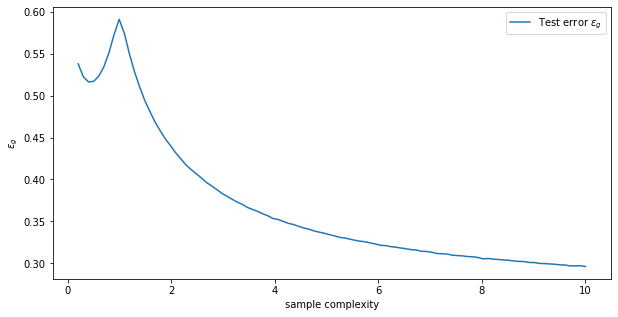

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
results.plot(x='sample_complexity', y='generr', style='-', ax=ax, label='Test error $\epsilon_g$')
plt.ylabel(r"$\epsilon_g$")
plt.xlabel(r"sample complexity")
plt.legend()

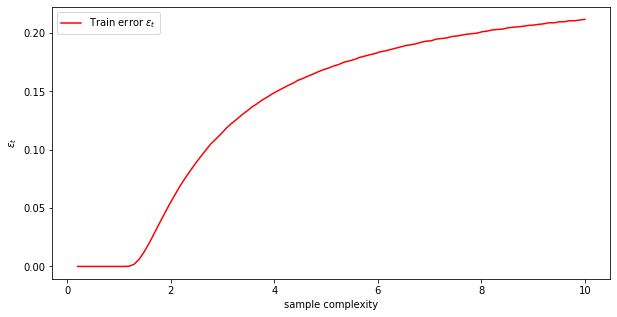

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
results.plot(x='sample_complexity', y='trainerr', style='-',color='red', ax=ax, label='Train error $\epsilon_t$')
plt.ylabel(r"$\epsilon_t$")
plt.xlabel(r"sample complexity")
plt.legend()

### Bayes optimal error

The following piece of code computes, for each value of $\alpha$, the Bayes optimal error in the classification task considered here. This will be a lower bound for the test error curve.

In [16]:
αs = np.linspace(αmin,αmax,steps)

def Φ(z):
    return 0.5*(1 + erf(z/np.sqrt(2.)))
def gaussian(x, var, mean=0):
    return  np.exp(-1/(2*var) * (x-mean)**2)/np.sqrt(2*np.pi*var)
def integ(k,η):
    K=η.shape[0]
    def integrand(xi):
        prod=1
        for u in range(K):
            if(u!=k):
                prod=prod*Φ(η[u]*(1/η[k]+xi)/η[k]+η[u]*np.log(ρ[k]/ρ[u]))
        return prod*gaussian(xi,1)
    int_lim=20.
    return quad(integrand,-int_lim,int_lim,limit=100,epsrel=1e-11)[0]
def error(α):
    η=np.sqrt(Δ*(1+Δ/(ρ*α)))
    error=1
    for k in range(K):
        error=error-ρ[k]*integ(k,η)
    return error
dataBO = {'sample_complexity': [], 'BOerr':[]}

for α in αs:
    BOerr = error(α)
    dataBO['sample_complexity'].append(α)
    dataBO['BOerr'].append(BOerr)

In [17]:
resultsBO = pd.DataFrame.from_dict(dataBO)

### Numerical experiments and comparison with theory

In [18]:
import experimentsK

In the same setting of the theoretical analysis above, run simulations to compare with the predictions. In the case of ridge loss, the solution can be obtained explicitely by matrix inversion. In the logistic case, we relie on the ```scipy``` solver ```LogisticRegression```. All solvers are in ```experimentsK``` Range of sample complexity and dimension have to be specified.

In [19]:
seeds = 10   #Number of samples
αmin  = 0.5  #Minimum value of the sample complexity
αmax  = 9.5  #Maximum value of the sample complexity
steps = 19    #Number of steps
d     = 2000 #Dimension

In [20]:
αs = np.linspace(αmin,αmax,steps)
dataE = {'lambda': [], 'sample_complexity': [],
           'trainerr': [], 'generr':[], 
           'stdEt': [], 'stdEg': []}
print('Simulate multiclass with K={} and loss {}, delta={}, lambda={}. Means model: {}'.format(K,loss,Δ,λ,model))

for α in αs:
    train_err, test_err, std_et, std_eg = experimentsK.simulate(K,α,λ,ρ,Δ,loss,model,seeds=seeds, dimension=d)
    dataE['lambda'].append(λ)
    dataE['sample_complexity'].append(α)
    dataE['trainerr'].append(train_err)
    dataE['generr'].append(test_err)
    dataE['stdEt'].append(std_et)
    dataE['stdEg'].append(std_eg)
    print("α="+str(round(α,1))+": Training error:"+str(train_err)+" test error:"+str(test_err))

Simulate multiclass with K=3 and loss qua, delta=0.5, lambda=0.001. Means model: random
α=0.5: Training error:0.0 test error:0.5214
α=1.0: Training error:0.0 test error:0.5845999999999999
α=1.5: Training error:0.013100000000000023 test error:0.49346666666666666
α=2.0: Training error:0.05389999999999999 test error:0.44345
α=2.5: Training error:0.0874 test error:0.40094
α=3.0: Training error:0.11461666666666667 test error:0.3847666666666667
α=3.5: Training error:0.1359857142857143 test error:0.36618571428571434
α=4.0: Training error:0.1495875 test error:0.356325
α=4.5: Training error:0.15758888888888892 test error:0.34178888888888886
α=5.0: Training error:0.16654000000000002 test error:0.33429
α=5.5: Training error:0.17745454545454545 test error:0.3288181818181818
α=6.0: Training error:0.18247500000000003 test error:0.32304166666666667
α=6.5: Training error:0.18695384615384614 test error:0.31693076923076924
α=7.0: Training error:0.18926428571428575 test error:0.30984285714285714
α=7.5: T

In [21]:
resultsE = pd.DataFrame.from_dict(dataE)

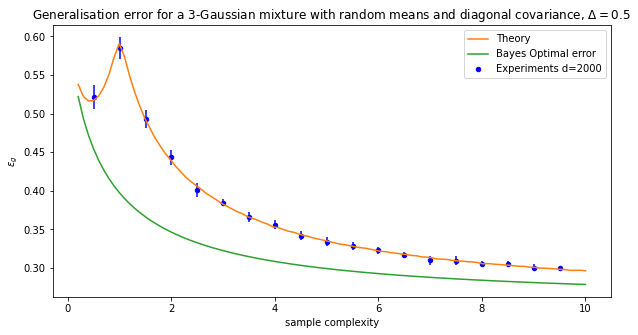

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title(r'Generalisation error for a {}-Gaussian mixture with {} means and diagonal covariance, $\Delta = {}$'.format(K,model,Δ))
resultsE.plot(x='sample_complexity', y='generr', kind='scatter', style='.', yerr='stdEg', ax=ax, color='blue', label='Experiments d={}'.format(d))
results.plot(x='sample_complexity', y='generr', style='-', ax=ax, label='Theory')
resultsBO.plot(x='sample_complexity', y='BOerr', style='-', ax=ax, label='Bayes Optimal error')
plt.ylabel(r"$\epsilon_g$")
plt.xlabel(r"sample complexity")
plt.legend()
plt.savefig('GenErr.jpg')

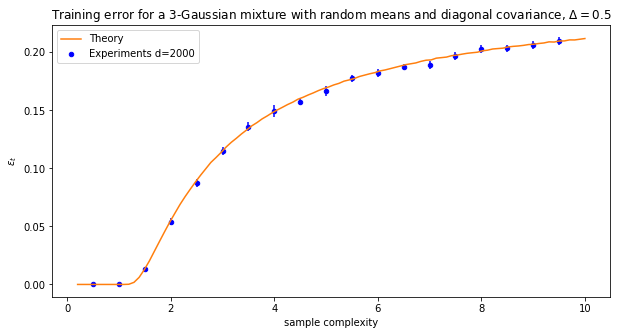

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title(r'Training error for a {}-Gaussian mixture with {} means and diagonal covariance, $\Delta = {}$'.format(K,model,Δ))
resultsE.plot(x='sample_complexity', y='trainerr', kind='scatter', style='.', yerr='stdEt', ax=ax, color='blue', label='Experiments d={}'.format(d))
results.plot(x='sample_complexity', y='trainerr', style='-', ax=ax, label='Theory')
plt.ylabel(r"$\epsilon_t$")
plt.xlabel(r"sample complexity")
plt.legend()
plt.savefig('TrainErr.jpg')